In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Transformer Complet: Encoder + Decoder

## Objectif
Implémenter un Transformer complet avec **Encoder ET Decoder** pour des tâches de séquence-à-séquence (traduction, génération, etc.)

## Architecture Complète
```
Source Sequence (English)
         ↓
    [ENCODER]
    • Multi-Head Self-Attention
    • Feed-Forward
    • N layers
         ↓
    Encoded Representation
         ↓
    [DECODER]
    • Masked Self-Attention
    • Cross-Attention (with Encoder)
    • Feed-Forward
    • N layers
         ↓
Target Sequence (French)
```

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

torch.manual_seed(42)
np.random.seed(42)

print("✓ Bibliothèques importées")
print(f"PyTorch version: {torch.__version__}")

✓ Bibliothèques importées
PyTorch version: 2.7.1+cu118


## 1. Composants de Base

In [4]:
# ========== SCALED DOT-PRODUCT ATTENTION ==========
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Attention(Q, K, V) = softmax(QK^T / √d_k) V
    
    Args:
        Q: (batch, num_heads, seq_len, d_k)
        K: (batch, num_heads, seq_len, d_k)
        V: (batch, num_heads, seq_len, d_v)
        mask: Optional mask
    """
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    attention = F.softmax(scores, dim=-1)
    output = torch.matmul(attention, V)
    
    return output, attention

print("✓ Scaled Dot-Product Attention défini")

✓ Scaled Dot-Product Attention défini


In [5]:
# ========== MULTI-HEAD ATTENTION ==========
class MultiHeadAttention(nn.Module):
    """Multi-Head Attention pour self-attention"""
    
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # Linear projections
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # Reshape for multi-head
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Attention
        attn_output, attention = scaled_dot_product_attention(Q, K, V, mask)
        
        # Concat heads
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(batch_size, -1, self.d_model)
        
        # Final linear
        output = self.W_o(attn_output)
        
        return output, attention

print("✓ Multi-Head Attention défini")

✓ Multi-Head Attention défini


In [6]:
# ========== POSITIONAL ENCODING ==========
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                            (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

print("✓ Positional Encoding défini")

✓ Positional Encoding défini


In [7]:
# ========== FEED-FORWARD NETWORK ==========
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

print("✓ Feed-Forward Network défini")

✓ Feed-Forward Network défini


## 2. Encoder Block

In [8]:
class EncoderBlock(nn.Module):
    """
    Un bloc Encoder:
    1. Multi-Head Self-Attention
    2. Add & Norm
    3. Feed-Forward
    4. Add & Norm
    """
    
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Self-attention
        attn_output, attention = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))
        
        return x, attention

print("✓ Encoder Block défini")

✓ Encoder Block défini


## 3. Decoder Block

Le décodeur a **3 sous-couches** au lieu de 2:
1. **Masked Self-Attention** - Ne peut voir que les tokens précédents
2. **Cross-Attention** - Attend sur la sortie de l'encodeur
3. **Feed-Forward** - Comme l'encodeur

In [9]:
class DecoderBlock(nn.Module):
    """
    Un bloc Decoder:
    1. Masked Multi-Head Self-Attention
    2. Add & Norm
    3. Multi-Head Cross-Attention (avec Encoder)
    4. Add & Norm
    5. Feed-Forward
    6. Add & Norm
    """
    
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        
        # Self-attention (masked)
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        
        # Cross-attention (avec encoder)
        self.cross_attention = MultiHeadAttention(d_model, num_heads)
        
        # Feed-forward
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        
        # Layer Norms
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        
        # Dropouts
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
    
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        """
        Args:
            x: Target sequence (batch, tgt_len, d_model)
            encoder_output: Encoder output (batch, src_len, d_model)
            src_mask: Source mask
            tgt_mask: Target mask (causal mask)
        """
        # 1. Masked Self-Attention
        self_attn_output, self_attention = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout1(self_attn_output))
        
        # 2. Cross-Attention avec l'encodeur
        cross_attn_output, cross_attention = self.cross_attention(
            query=x,
            key=encoder_output,
            value=encoder_output,
            mask=src_mask
        )
        x = self.norm2(x + self.dropout2(cross_attn_output))
        
        # 3. Feed-Forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout3(ff_output))
        
        return x, self_attention, cross_attention

print("✓ Decoder Block défini")

✓ Decoder Block défini


## 4. Encoder Complet

In [10]:
class Encoder(nn.Module):
    """
    Encoder complet avec N blocs
    """
    
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, dropout=0.1, max_len=5000):
        super().__init__()
        
        self.d_model = d_model
        
        # Embedding + Positional Encoding
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        
        # Stack de N blocs encoder
        self.layers = nn.ModuleList([
            EncoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
    
    def forward(self, x, mask=None):
        """
        Args:
            x: (batch, seq_len) token indices
            mask: Optional mask
        """
        # Embedding + scaling
        x = self.embedding(x) * math.sqrt(self.d_model)
        
        # Positional encoding
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        # Pass through encoder blocks
        attentions = []
        for layer in self.layers:
            x, attention = layer(x, mask)
            attentions.append(attention)
        
        return x, attentions

print("✓ Encoder complet défini")

✓ Encoder complet défini


## 5. Decoder Complet

In [11]:
class Decoder(nn.Module):
    """
    Decoder complet avec N blocs
    """
    
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, dropout=0.1, max_len=5000):
        super().__init__()
        
        self.d_model = d_model
        
        # Embedding + Positional Encoding
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        
        # Stack de N blocs decoder
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
    
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        """
        Args:
            x: (batch, tgt_len) target token indices
            encoder_output: (batch, src_len, d_model)
            src_mask: Source mask
            tgt_mask: Target (causal) mask
        """
        # Embedding + scaling
        x = self.embedding(x) * math.sqrt(self.d_model)
        
        # Positional encoding
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        # Pass through decoder blocks
        self_attentions = []
        cross_attentions = []
        
        for layer in self.layers:
            x, self_attn, cross_attn = layer(x, encoder_output, src_mask, tgt_mask)
            self_attentions.append(self_attn)
            cross_attentions.append(cross_attn)
        
        return x, self_attentions, cross_attentions

print("✓ Decoder complet défini")

✓ Decoder complet défini


## 6. Transformer Complet (Encoder + Decoder)

In [12]:
class Transformer(nn.Module):
    """
    Transformer complet avec Encoder et Decoder
    Pour tâches seq2seq: traduction, résumé, etc.
    """
    
    def __init__(self, 
                 src_vocab_size,
                 tgt_vocab_size,
                 d_model=512,
                 num_heads=8,
                 d_ff=2048,
                 num_encoder_layers=6,
                 num_decoder_layers=6,
                 dropout=0.1,
                 max_len=5000):
        super().__init__()
        
        # Encoder
        self.encoder = Encoder(
            vocab_size=src_vocab_size,
            d_model=d_model,
            num_heads=num_heads,
            d_ff=d_ff,
            num_layers=num_encoder_layers,
            dropout=dropout,
            max_len=max_len
        )
        
        # Decoder
        self.decoder = Decoder(
            vocab_size=tgt_vocab_size,
            d_model=d_model,
            num_heads=num_heads,
            d_ff=d_ff,
            num_layers=num_decoder_layers,
            dropout=dropout,
            max_len=max_len
        )
        
        # Output projection
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        
        self.d_model = d_model
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """
        Args:
            src: (batch, src_len) source sequence
            tgt: (batch, tgt_len) target sequence
            src_mask: Source mask
            tgt_mask: Target causal mask
        
        Returns:
            logits: (batch, tgt_len, tgt_vocab_size)
        """
        # Encoder
        encoder_output, encoder_attentions = self.encoder(src, src_mask)
        
        # Decoder
        decoder_output, self_attentions, cross_attentions = self.decoder(
            tgt, encoder_output, src_mask, tgt_mask
        )
        
        # Output projection
        logits = self.output_projection(decoder_output)
        
        return logits, {
            'encoder_attentions': encoder_attentions,
            'decoder_self_attentions': self_attentions,
            'decoder_cross_attentions': cross_attentions
        }
    
    def encode(self, src, src_mask=None):
        """Encode seulement (pour génération)"""
        return self.encoder(src, src_mask)[0]
    
    def decode(self, tgt, encoder_output, src_mask=None, tgt_mask=None):
        """Decode seulement (pour génération)"""
        decoder_output, _, _ = self.decoder(tgt, encoder_output, src_mask, tgt_mask)
        return self.output_projection(decoder_output)

print("✓ Transformer complet (Encoder + Decoder) défini!")

✓ Transformer complet (Encoder + Decoder) défini!


## 7. Fonctions Utilitaires pour les Masques

In [13]:
def create_padding_mask(seq, pad_idx=0):
    """
    Créer un masque pour les tokens de padding
    
    Args:
        seq: (batch, seq_len)
        pad_idx: Index du token PAD
    
    Returns:
        mask: (batch, 1, 1, seq_len)
    """
    mask = (seq != pad_idx).unsqueeze(1).unsqueeze(2)
    return mask

def create_causal_mask(size):
    """
    Créer un masque causal (look-ahead mask)
    Empêche le décodeur de voir les tokens futurs
    
    Args:
        size: Taille de la séquence
    
    Returns:
        mask: (1, size, size)
    """
    mask = torch.triu(torch.ones(size, size), diagonal=1).type(torch.uint8)
    return mask == 0

def create_masks(src, tgt, pad_idx=0):
    """
    Créer tous les masques nécessaires
    
    Args:
        src: (batch, src_len)
        tgt: (batch, tgt_len)
        pad_idx: Index du padding
    """
    # Source padding mask
    src_mask = create_padding_mask(src, pad_idx)
    
    # Target padding mask
    tgt_padding_mask = create_padding_mask(tgt, pad_idx)
    
    # Target causal mask
    tgt_len = tgt.size(1)
    tgt_causal_mask = create_causal_mask(tgt_len).to(tgt.device)
    
    # Combine target masks
    tgt_mask = tgt_padding_mask & tgt_causal_mask.unsqueeze(0)
    
    return src_mask, tgt_mask

print("✓ Fonctions de masques définies")

✓ Fonctions de masques définies


## 8. Test du Transformer Complet

In [14]:
# Paramètres
src_vocab_size = 1000  # Vocabulaire source (ex: anglais)
tgt_vocab_size = 1000  # Vocabulaire cible (ex: français)
d_model = 256
num_heads = 8
d_ff = 1024
num_layers = 3

# Créer le modèle
model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    num_encoder_layers=num_layers,
    num_decoder_layers=num_layers
)

print("=== Transformer Créé ===")
print(f"Source vocab: {src_vocab_size}")
print(f"Target vocab: {tgt_vocab_size}")
print(f"d_model: {d_model}")
print(f"num_heads: {num_heads}")
print(f"Encoder layers: {num_layers}")
print(f"Decoder layers: {num_layers}")

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n=== Paramètres ===")
print(f"Total: {total_params:,}")
print(f"Entraînables: {trainable_params:,}")

=== Transformer Créé ===
Source vocab: 1000
Target vocab: 1000
d_model: 256
num_heads: 8
Encoder layers: 3
Decoder layers: 3

=== Paramètres ===
Total: 6,298,600
Entraînables: 6,298,600


In [15]:
# Test avec des données aléatoires
batch_size = 4
src_len = 10
tgt_len = 12

# Séquences source et cible (indices)
src = torch.randint(1, src_vocab_size, (batch_size, src_len))
tgt = torch.randint(1, tgt_vocab_size, (batch_size, tgt_len))

# Créer les masques
src_mask, tgt_mask = create_masks(src, tgt, pad_idx=0)

print("=== Données de test ===")
print(f"Source shape: {src.shape}")
print(f"Target shape: {tgt.shape}")
print(f"Source mask shape: {src_mask.shape}")
print(f"Target mask shape: {tgt_mask.shape}")

# Forward pass
with torch.no_grad():
    logits, attentions = model(src, tgt, src_mask, tgt_mask)

print(f"\n=== Résultats ===")
print(f"Logits shape: {logits.shape}")
print(f"  → (batch={batch_size}, tgt_len={tgt_len}, vocab={tgt_vocab_size})")

print(f"\nEncoder attentions: {len(attentions['encoder_attentions'])} layers")
print(f"Decoder self-attentions: {len(attentions['decoder_self_attentions'])} layers")
print(f"Decoder cross-attentions: {len(attentions['decoder_cross_attentions'])} layers")

print("\n✓ Forward pass réussi!")

=== Données de test ===
Source shape: torch.Size([4, 10])
Target shape: torch.Size([4, 12])
Source mask shape: torch.Size([4, 1, 1, 10])
Target mask shape: torch.Size([4, 1, 12, 12])

=== Résultats ===
Logits shape: torch.Size([4, 12, 1000])
  → (batch=4, tgt_len=12, vocab=1000)

Encoder attentions: 3 layers
Decoder self-attentions: 3 layers
Decoder cross-attentions: 3 layers

✓ Forward pass réussi!


## 9. Visualisation des Attention Maps

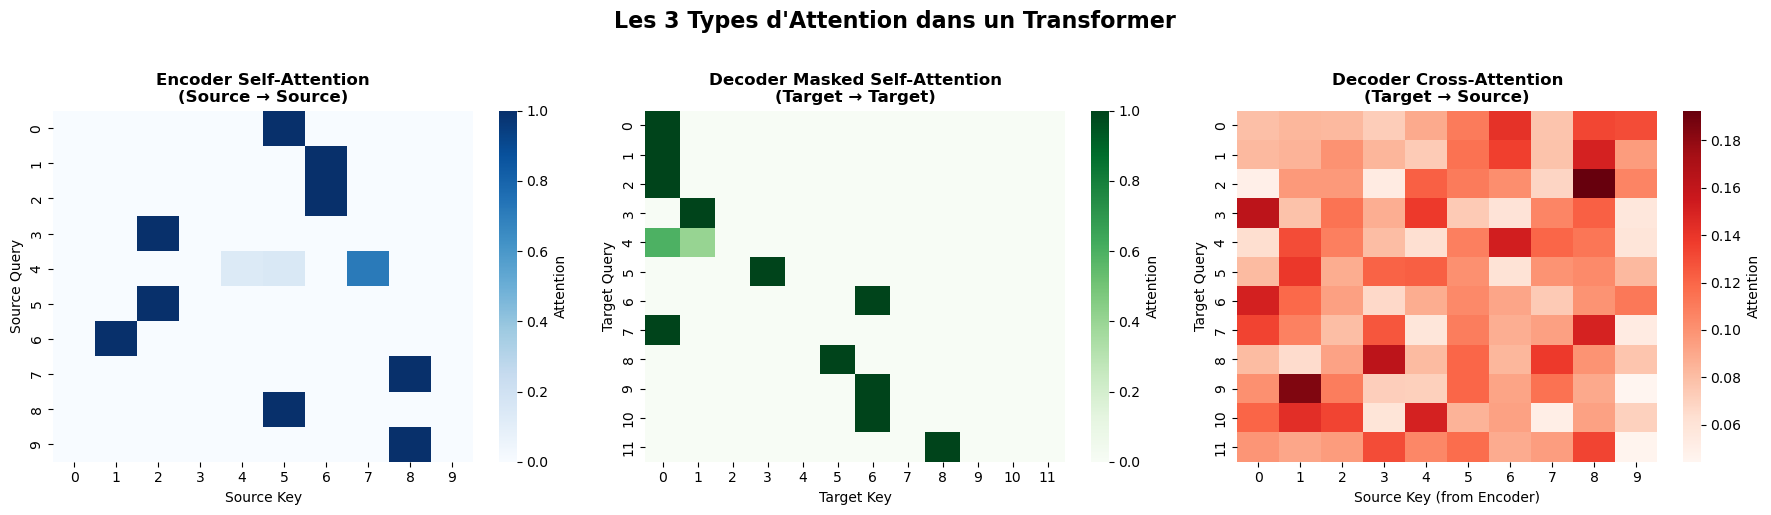


=== Interprétation ===
1. Encoder Self-Attention: Chaque mot source regarde les autres mots sources
2. Decoder Masked Self-Attention: Chaque mot cible regarde les mots précédents seulement
3. Decoder Cross-Attention: Chaque mot cible regarde tous les mots sources


In [16]:
# Visualiser les différents types d'attention
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Encoder Self-Attention
enc_attn = attentions['encoder_attentions'][0][0, 0].detach().numpy()  # Layer 0, Head 0
sns.heatmap(enc_attn, cmap='Blues', ax=axes[0], cbar_kws={'label': 'Attention'})
axes[0].set_title('Encoder Self-Attention\n(Source → Source)', fontweight='bold')
axes[0].set_xlabel('Source Key')
axes[0].set_ylabel('Source Query')

# 2. Decoder Self-Attention (masked)
dec_self_attn = attentions['decoder_self_attentions'][0][0, 0].detach().numpy()
sns.heatmap(dec_self_attn, cmap='Greens', ax=axes[1], cbar_kws={'label': 'Attention'})
axes[1].set_title('Decoder Masked Self-Attention\n(Target → Target)', fontweight='bold')
axes[1].set_xlabel('Target Key')
axes[1].set_ylabel('Target Query')

# 3. Decoder Cross-Attention
dec_cross_attn = attentions['decoder_cross_attentions'][0][0, 0].detach().numpy()
sns.heatmap(dec_cross_attn, cmap='Reds', ax=axes[2], cbar_kws={'label': 'Attention'})
axes[2].set_title('Decoder Cross-Attention\n(Target → Source)', fontweight='bold')
axes[2].set_xlabel('Source Key (from Encoder)')
axes[2].set_ylabel('Target Query')

plt.suptitle('Les 3 Types d\'Attention dans un Transformer', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n=== Interprétation ===")
print("1. Encoder Self-Attention: Chaque mot source regarde les autres mots sources")
print("2. Decoder Masked Self-Attention: Chaque mot cible regarde les mots précédents seulement")
print("3. Decoder Cross-Attention: Chaque mot cible regarde tous les mots sources")

## 10. Exemple de Génération (Greedy Decoding)

In [17]:
def greedy_decode(model, src, src_mask, max_len, start_token, end_token):
    """
    Génération greedy: choisir le token avec la probabilité max à chaque étape
    
    Args:
        model: Transformer model
        src: Source sequence (batch=1, src_len)
        src_mask: Source mask
        max_len: Longueur max de génération
        start_token: Token de début
        end_token: Token de fin
    """
    model.eval()
    
    # Encoder une fois
    with torch.no_grad():
        encoder_output = model.encode(src, src_mask)
    
    # Commencer avec le start token
    tgt = torch.LongTensor([[start_token]])
    
    for i in range(max_len):
        # Créer le masque causal
        tgt_mask = create_causal_mask(tgt.size(1)).unsqueeze(0)
        
        # Décoder
        with torch.no_grad():
            output = model.decode(tgt, encoder_output, src_mask, tgt_mask)
        
        # Prendre le dernier token prédit
        next_token = output[:, -1, :].argmax(dim=-1)
        
        # Ajouter à la séquence
        tgt = torch.cat([tgt, next_token.unsqueeze(0)], dim=1)
        
        # Arrêter si end token
        if next_token.item() == end_token:
            break
    
    return tgt

# Test de génération
src_test = torch.randint(1, src_vocab_size, (1, 8))
src_mask_test = create_padding_mask(src_test)

generated = greedy_decode(
    model=model,
    src=src_test,
    src_mask=src_mask_test,
    max_len=15,
    start_token=1,
    end_token=2
)

print("=== Exemple de Génération ===")
print(f"Source: {src_test.squeeze().tolist()}")
print(f"Generated: {generated.squeeze().tolist()}")
print(f"\nLongueur générée: {generated.size(1)} tokens")

=== Exemple de Génération ===
Source: [902, 39, 262, 180, 441, 229, 477, 550]
Generated: [1, 740, 831, 605, 544, 112, 868, 918, 853, 678, 213, 86, 371, 292, 128, 732]

Longueur générée: 16 tokens


## 11. Application: Mini Traducteur

In [18]:
class MiniTranslator:
    """
    Mini système de traduction utilisant le Transformer
    """
    
    def __init__(self, model, src_vocab, tgt_vocab):
        self.model = model
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.src_word2idx = {w: i for i, w in enumerate(src_vocab)}
        self.tgt_word2idx = {w: i for i, w in enumerate(tgt_vocab)}
        self.tgt_idx2word = {i: w for w, i in self.tgt_word2idx.items()}
    
    def encode_sentence(self, sentence, word2idx):
        """Convertir une phrase en indices"""
        return [word2idx.get(word, word2idx.get('<UNK>', 0)) 
                for word in sentence.split()]
    
    def decode_indices(self, indices):
        """Convertir des indices en phrase"""
        return ' '.join([self.tgt_idx2word.get(idx, '<UNK>') 
                        for idx in indices if idx > 2])  # Skip special tokens
    
    def translate(self, sentence, max_len=50):
        """Traduire une phrase"""
        # Encoder
        src_indices = self.encode_sentence(sentence, self.src_word2idx)
        src = torch.LongTensor([src_indices]).unsqueeze(0)
        src_mask = create_padding_mask(src)
        
        # Générer
        tgt_indices = greedy_decode(
            self.model, src, src_mask, max_len,
            start_token=1, end_token=2
        )
        
        # Décoder
        translation = self.decode_indices(tgt_indices.squeeze().tolist())
        
        return translation

# Exemple avec des vocabulaires fictifs
src_vocab = ['<PAD>', '<START>', '<END>', '<UNK>'] + \
            ['hello', 'world', 'good', 'morning', 'how', 'are', 'you']
tgt_vocab = ['<PAD>', '<START>', '<END>', '<UNK>'] + \
            ['bonjour', 'monde', 'bon', 'matin', 'comment', 'allez', 'vous']

# Créer le traducteur
translator = MiniTranslator(model, src_vocab, tgt_vocab)

print("=== Mini Traducteur Créé ===")
print(f"Source vocab size: {len(src_vocab)}")
print(f"Target vocab size: {len(tgt_vocab)}")
print("\nNote: Le modèle n'est pas entraîné, les traductions seront aléatoires")

=== Mini Traducteur Créé ===
Source vocab size: 11
Target vocab size: 11

Note: Le modèle n'est pas entraîné, les traductions seront aléatoires


## Résumé

### Architecture Complète Implémentée:

```
SOURCE (Anglais)                    TARGET (Français)
      ↓                                    ↓
  Embedding                            Embedding
      +                                    +
  Positional Encoding              Positional Encoding
      ↓                                    ↓
┌──────────────┐                   ┌──────────────────┐
│   ENCODER    │                   │     DECODER      │
│              │                   │                  │
│ Self-Attn    │                   │ Masked Self-Attn │
│ Add & Norm   │                   │ Add & Norm       │
│ Feed-Forward │──────────────────→│ Cross-Attention  │
│ Add & Norm   │  Encoder Output   │ Add & Norm       │
│              │                   │ Feed-Forward     │
│ × N layers   │                   │ Add & Norm       │
│              │                   │                  │
│              │                   │ × N layers       │
└──────────────┘                   └──────────────────┘
                                           ↓
                                   Linear + Softmax
                                           ↓
                                   Output Probabilities
```

### 3 Types d'Attention:

1. **Encoder Self-Attention**
   - Chaque mot source regarde tous les mots sources
   - Pas de masque

2. **Decoder Masked Self-Attention**
   - Chaque mot cible regarde les mots précédents seulement
   - Masque causal (triangulaire)

3. **Decoder Cross-Attention**
   - Chaque mot cible regarde tous les mots sources
   - Q du décodeur, K,V de l'encodeur

### Applications:
- Traduction automatique
- Résumé de texte
- Génération de texte conditionnelle
- Question-answering
- Dialogue systems

### Prochaines Étapes:
- Entraîner sur un vrai dataset de traduction
- Implémenter beam search
- Ajouter label smoothing
- Optimiser avec mixed precision